# Mousai: An Open-Source General Purpose Harmonic Balance Solver

ASME Dayton Engineering Sciences Symposium 2017  
Joseph C. Slater, October 23, 2017

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mousai as ms
from scipy import pi, sin
matplotlib.rcParams['figure.figsize'] = (11, 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Overview
A wide array of contemporary problems can be represented by nonlinear ordinary differential equations with solutions that can be represented by Fourier Series:
  * **Limit cycle oscillation of wings/blades**
  * Flapping motion of birds/insects/ornithopters
  * Flagellum (threadlike cellular structures that enable bacteria etc. to swim)
  * Shaft rotation, especially including rubbing or nonlinear bearing contacts
  * **Engines**
  * Radio/sonar/radar electronics
  * Wireless power transmission
  * Power converters
  * Boat/ship motions and interactions

  * **Cardio systems** (heart/arteries/veins)
  * Ultrasonic systems transversing nonlinear media
  * Responses of composite materials or materials with cracks
  * Near buckling behavior of vibrating columns
  * Nonlinearities in power systems
  * **Energy harvesting systems**
  * **Wind turbines**
  * Radio Frequency Integrated Circuits
  * **Any system with nonlinear coatings/friction damping, air damping, etc.**
  
These can all be observed in a quick literature search on 'Harmonic Balance'. 

## Why (did I) write Mousai?

* The ability to code harmonic balance seems to be publishable by itself
    * It's not research- it's just application of a known family of technique
* A limited number of people have this knowledge and skill
    * Most cannot access this technique
    * "Research effort" is spent coding the technique, not doing research

### Why write Mousai? (continued)
* Matlab command eig unleashed power to the masses
  * Very few papers are published on eigensolutions- they have to be better than ``eig``
  * ``eig`` only provides simple access to high-end eigensolvers written in ``C`` and ``Fortran``
  * Undergraduates with no practical understanding of the algorithms easily solve problems
    that were intractable a few decades ago.
  * *Access* and *ease of use* of such techniques enable *greater science* and *greater research*.
  * The real world is nonlinear, but **linear analysis dominates because the tools are easier to use**.
  * With ``Mousai``, an undergraduate can solve a nonlinear harmonic response problem easier then a PhD can today.

## Theory: 
### Linear Solution

- Most dynamics systems can be modeled as a first order differential equation

\begin{equation}\ddot{\mathbf{z}}(t)=\mathbf{f}(\mathbf{z}(t),\mathbf{u}(t))\end{equation}

    - Use finite differences
    - Use Galerkin methods (Finite Elements)
    - Of course- discrete objects
- This is the common *State-Space* form:
    -solutions exceedingly well known if it is linear 

- Finding the oscillatory response, after dissipation of the transient response, requires **long** time marching. 
    - Without damping, this may not even been feasible. 
    - With damping, tens, hundreds, or thousands of cycles, therefore thousands of times steps at minimum. 


For a linear system in the frequency domain this is

\begin{equation}j\omega\mathbf{Z}(\omega)=\mathbf{f}(\mathbf{Z}(\omega),\mathbf{U}(\omega))\end{equation}

\begin{equation}j\omega\mathbf{Z}(\omega)=A\mathbf{Z}(\omega)+B\mathbf{U}(\omega)\end{equation}

where

\begin{equation}A = \frac{\partial \mathbf{f}(\mathbf{Z}(\omega),\mathbf{U}(\omega))}{\partial\mathbf{Z}(\omega)},\qquad
B = \frac{\partial \mathbf{f}(\mathbf{Z}(\omega),\mathbf{U}(\omega))}{\partial\mathbf{U}(\omega)}\end{equation}

are constant matrices. 

The solution is:
\begin{equation}\mathbf{Z}(\omega) = \left(Ij\omega-A\right)^{-1}B\mathbf{U}(\omega)\end{equation}
Where the magnitudes and phases of the elements of $\mathbf{Z}$ provide the amplitudes and phases of the harmonic response of each state at the frequency $\omega$.

### Nonlinear solution

- For a nonlinear system in the frequency domain we assume a Fourier series solution
\begin{equation}
\mathbf{z}(t)=\lim_{N\to\infty}\sum_{n=-N}^{N}\mathbf{Z}_n e^{j n \omega t}
\end{equation}

- $N=1$ for a single harmonic. $n=0$ is the constant term.
- This can be substituted into the governing equation to find $\dot{\mathbf{z}}(t)$:
\begin{equation}
\dot{\mathbf{z}}(t)=\mathbf{f}(\mathbf{z}(t),\mathbf{u}(t))
\end{equation}
- This is actually a function call to a Finite Element Package, CFD, Matlab function, - whatever your solver uses to get derivatives 

- We can also find $\dot{\mathbf{z}}(t)$ from the derivative of the Fourier Series:
\begin{equation}
\dot{\mathbf{z}}(t)=\lim_{N\to\infty}\sum_{n=-N}^{N}j n \omega\mathbf{Z}_n e^{j n \omega t}
\end{equation}

- The difference between these methods is zero when $\mathbf{Z}_n$ are correct.

\begin{equation}
 \mathbf{0} \approx\sum_{n=-N}^{N}j n\omega \mathbf{Z}_n e^{j n \omega t}-\mathbf{f}\left(\sum_{n=-N}^{N}\mathbf{Z}_n e^{j n \omega t},\mathbf{u}(t)\right)
\end{equation}

- These operations are wrapped inside a function that returns this error
- This function is used by a Newton-Krylov nonlinear algebraic solver. 
- Calls any solver in the SciPy family of solvers with the ability to easily pass through parameters to the solver *and* to the external derivative evaluator.


## Examples:


### Duffing Oscillator

\begin{equation}
\ddot{x}+0.1\dot{x}+x+0.1 x^3=\sin(\omega t)
\end{equation}

In [3]:
# Define our function (Python)
def duff_osc_ss(x, params):
    omega = params['omega']
    t = params['cur_time']
    xd = np.array([[x[1]],
                   [-x[0] - 0.1 * x[0]**3 - 0.1 * x[1] + 1 * sin(omega * t)]])
    return xd

In [4]:
# Arguments are name of derivative function, number of states, driving frequency,
# form of the equation, and number of harmonics

t, x, e, amps, phases = ms.hb_time(duff_osc_ss, num_variables=2, omega=.1,
                                 eqform='first_order', num_harmonics=5)
print('Displacement amplitude is ', amps[0])
print('Velocity amplitude is ', amps[1])

Displacement amplitude is  0.946956354668
Velocity amplitude is  0.0946956354558


#### Mousai can easily recreate the near-continuous response

````python
time, xc = ms.time_history(t, x)
````

In [17]:
def pltcont():
    time, xc = ms.time_history(t, x)
    disp_plot, _ = plt.plot(time, xc.T[:, 0], t,
                            x.T[:, 0], '*b', label='Displacement')
    vel_plot, _ = plt.plot(time, xc.T[:, 1], 'r',
                           t, x.T[:, 1], '*r', label='Velocity')
    plt.legend(handles=[disp_plot, vel_plot])
    plt.xlabel('Time (sec)')
    plt.title('Response of Duffing Oscillator at 0.0159 rad/sec')
    plt.ylabel('Response')
    plt.legend
    plt.grid(True)

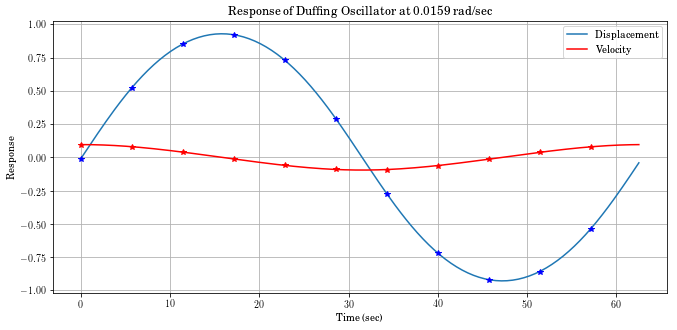

In [18]:
fig=plt.figure()
ax=fig.add_subplot(111)
time, xc = ms.time_history(t, x)
disp_plot, _ = ax.plot(time, xc.T[:, 0], t,
                            x.T[:, 0], '*b', label='Displacement')
vel_plot, _ = ax.plot(time, xc.T[:, 1], 'r',
                           t, x.T[:, 1], '*r', label='Velocity')
ax.legend(handles=[disp_plot, vel_plot])
ax.set_xlabel('Time (sec)')
ax.set_title('Response of Duffing Oscillator at 0.0159 rad/sec')
ax.set_ylabel('Response')
ax.legend
ax.grid(True)

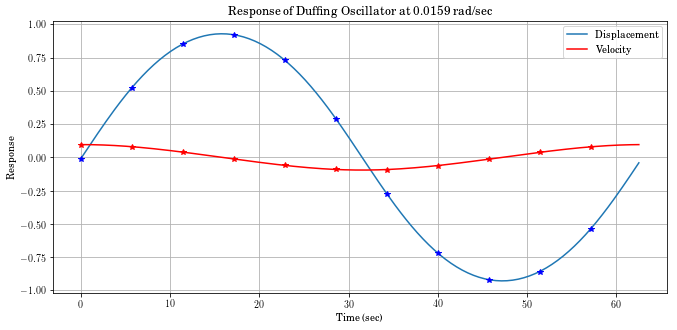

In [19]:
pltcont()# abbreviated plotting function

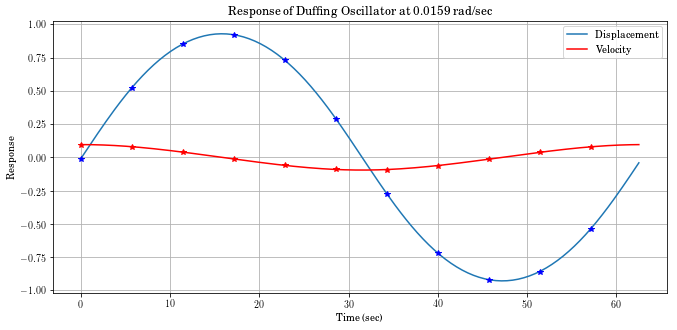

In [20]:
time, xc = ms.time_history(t, x)
disp_plot, _ = plt.plot(time, xc.T[:, 0], t,
                        x.T[:, 0], '*b', label='Displacement')
vel_plot, _ = plt.plot(time, xc.T[:, 1], 'r',
                       t, x.T[:, 1], '*r', label='Velocity')
plt.legend(handles=[disp_plot, vel_plot])
plt.xlabel('Time (sec)')
plt.title('Response of Duffing Oscillator at 0.0159 rad/sec')
plt.ylabel('Response')
plt.legend
plt.grid(True)

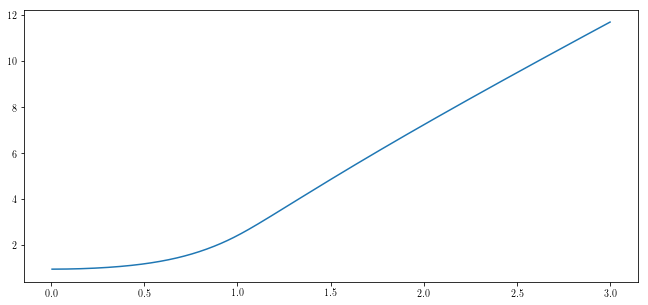

In [21]:
omega = np.arange(0, 3, 1 / 200) + 1 / 200
amp = sp.zeros_like(omega)
amp[:] = np.nan
t, x, e, amps, phases = ms.hb_time(duff_osc_ss, num_variables=2,
                                 omega=1 / 200, eqform='first_order', num_harmonics=1)
for i, freq in enumerate(omega):
    # Here we try to obtain solutions, but if they don't work,
    # we ignore them by inserting `np.nan` values.
    x = x - sp.average(x)
    try:
        t, x, e, amps, phases =
        ms.hb_time(duff_osc_ss, x0=x,
                 omega=freq, eqform='first_order', num_harmonics=1)
        amp[i] = amps[0]
    except:
        amp[i] = np.nan
    if np.isnan(amp[i]):
        break
plt.plot(omega, amp)

#### Let's sweep through driving frequencies to find a frequency response function

In [7]:
omegal = np.arange(3, .03, -1 / 200) + 1 / 200
ampl = sp.zeros_like(omegal)
ampl[:] = np.nan
t, x, e, amps, phases = ms.hb_time(duff_osc_ss, num_variables=2,
                                 omega=3, eqform='first_order', num_harmonics=1)
for i, freq in enumerate(omegal):
    # Here we try to obtain solutions, but if they don't work,
    # we ignore them by inserting `np.nan` values.
    x = x - np.average(x)
    try:
        t, x, e, amps, phases =
        ms.hb_time(duff_osc_ss, x0=x,
                 omega=freq, eqform='first_order', num_harmonics=1)
        ampl[i] = amps[0]
    except:
        ampl[i] = np.nan
    if np.isnan(ampl[i]):
        break

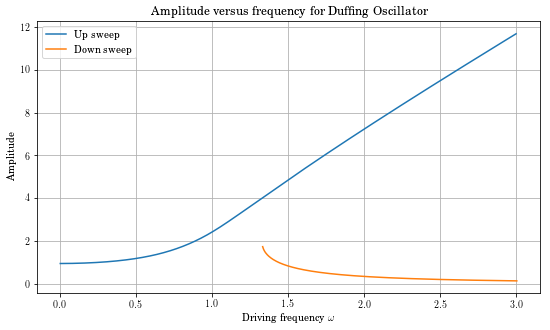

In [8]:
plt.plot(omega,amp, label='Up sweep')
plt.plot(omegal,ampl, label='Down sweep')
plt.legend()
plt.title('Amplitude versus frequency for Duffing Oscillator')
plt.xlabel('Driving frequency $\\omega$')
plt.ylabel('Amplitude')
plt.grid()

### Two degree of freedom system

$
\begin{bmatrix}
1&0\\
0&1
\end{bmatrix}
\begin{bmatrix}
\ddot{x}_1\\ \ddot{x}_2\end{bmatrix}
+
\begin{bmatrix}
2&-1 \\
-1&2
\end{bmatrix}
\begin{bmatrix}
{x}_1\\{x}_2\end{bmatrix}
+$ $
\begin{bmatrix}
\alpha x_{1}^{3}\\
0
\end{bmatrix}
$ $=
\begin{bmatrix}
0 \\
A \sin(\omega t)
\end{bmatrix}
$

In [9]:
def two_dof_demo(x, params):
    omega = params['omega']
    t = params['cur_time']
    force_amplitude = params['force_amplitude']
    alpha = params['alpha']
    # The following could call an external code to obtain the state derivatives
    xd = np.array([[x[1]],
                   [-2 * x[0] - alpha * x[0]**3 + x[2]],
                   [x[3]],
                   [-2 * x[2] + x[0]]] + force_amplitude * np.sin(omega * t))
    return xd

#### Let's find a response. 

In [10]:
parameters = {'force_amplitude': 0.2}
parameters['alpha'] = 0.4
t, x, e, amps, phases = ms.hb_time(two_dof_demo, num_variables=4,
                                 omega=1.2, eqform='first_order', params=parameters)
amps

array([ 0.86696762,  0.89484597,  0.99030411,  1.04097851])

#### Or a parametric study of response amplitude versus nonlinearity.

In [11]:
alpha = np.linspace(-1, .45, 2000)
amp = np.zeros_like(alpha)
for i, alphai in enumerate(alpha):
    parameters['alpha'] = alphai
    t, x, e, amps, phases = ms.hb_time(two_dof_demo, num_variables=4, omega=1.2,
                                     eqform='first_order', params=parameters)
    amp[i] = amps[0]

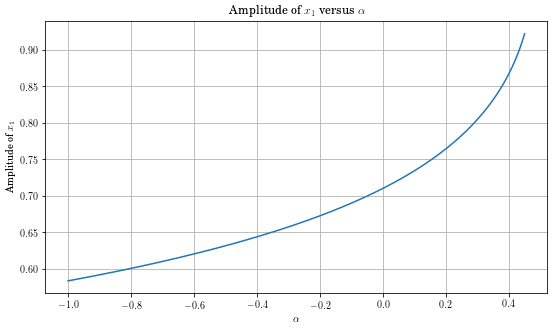

In [12]:
plt.plot(alpha,amp)
plt.title('Amplitude of $x_1$ versus $\\alpha$')
plt.ylabel('Amplitude of $x_1$')
plt.xlabel('$\\alpha$')
plt.grid()

### Two degree of freedom system with Coulomb Damping

$
\begin{bmatrix}
1&0\\
0&1
\end{bmatrix}
\begin{bmatrix}
\ddot{x}_1\\ \ddot{x}_2\end{bmatrix}
+
\begin{bmatrix}
2&-1 \\
-1&2
\end{bmatrix}
\begin{bmatrix}
{x}_1\\{x}_2\end{bmatrix}
+$ $
\begin{bmatrix}
\mu |\dot{x}|_{1}\\
0
\end{bmatrix}
$ $=
\begin{bmatrix}
0 \\
A \sin(\omega t)
\end{bmatrix}
$

In [13]:
def two_dof_coulomb(x, params):
    omega = params['omega']
    t = params['cur_time']
    force_amplitude = params['force_amplitude']
    mu = params['mu']
    # The following could call an external code to obtain the state derivatives
    xd = np.array([[x[1]],
                   [-2 * x[0] - mu * np.abs(x[1]) + x[2]],
                   [x[3]],
                   [-2 * x[2] + x[0]]] + force_amplitude * np.sin(omega * t))
    return xd

In [14]:
parameters = {'force_amplitude': 0.2}
parameters['mu'] = 0.1
t, x, e, amps, phases = ms.hb_time(two_dof_coulomb, num_variables=4,
                                 omega=1.2, eqform='first_order', params=parameters)
amps

array([ 0.68916938,  0.68228249,  0.67299987,  0.66065012])

In [31]:
mu = np.linspace(0, 1.0, 200)
amp = np.zeros_like(mu)
for i, mui in enumerate(mu):
    parameters['mu'] = mui
    t, x, e, amps, phases = ms.hb_time(two_dof_coulomb, num_variables=4, omega=1.2,
                                     eqform='first_order', num_harmonics=3, params=parameters)
    amp[i] = amps[0]

#### Too much Coulomb friction can increase the response. 
* Did you know that? 
* This damping shifted resonance. 

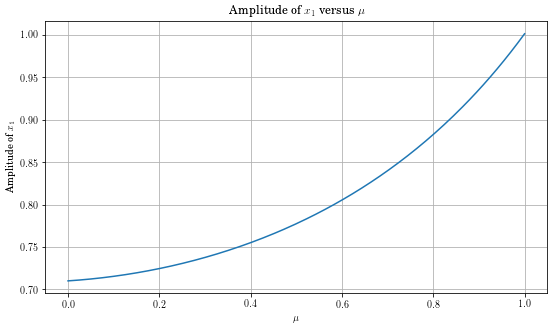

In [32]:
plt.plot(mu,amp)
plt.title('Amplitude of $x_1$ versus $\\mu$')
plt.ylabel('Amplitude of $x_1$')
plt.xlabel('$\\mu$')
plt.grid()

### But can I solve an equation in one line? Yes!!!

Damped Duffing oscillator in one command.

In [25]:
out = ms.hb_time(lambda x, v,
               params: np.array([[-x - .1 * x**3 - .1 * v + 1 *
                                  sin(params['omega'] * params['cur_time'])]]),
               num_variables=1, omega=.7, num_harmonics=1)
out[3][0]

1.4779630014433971

OK - that's a bit obtuse. I wouldn't do that normally, but Mousai can. 

## How to get this?

* Install Scientific Python from [SciPy.org](https://www.scipy.org/install.html)
    * AFRL: See your tech support to get the Enthought distribution installed
* See the Mousai [documents for](https://josephcslater.github.io/mousai/index.html) installation instructions
    * `pip install mousai`
    * AFRL: Talk to me- install is easy if I send you the files.
* See [Mousai on GitHub](https://github.com/josephcslater/mousai) (https://github.com/josephcslater/mousai)


## Conclusions

* Nonlinear frequency solutions are within reach of undergraduates
* Installation is trivial
* Already in use (GitHub logs indicate dozens of users)
* Custom special case and proprietary solvers such as BDamper can be replaced for free
* Research potential is about to be unleashed

## Future

* Add time-averaging method
    * currently requires high number of harmonics for non-smooth systems
* Add masking of known harmonics (average is often fixed and known)
* Automated sweep control
* Branch following
* Condense the one-line method
* Evaluate on large scale problems
    * Currently attempting to hook to ANSYS
* Parallelize 
* Leverage CUDA